In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
'''
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))'''

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"\nimport os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))"

**Importing the Libraries**

In [2]:
import os
import numpy as np
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import tensorflow.keras.utils as ku
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

**Making a Dataset for the Multiple kinds of forms**

In [3]:
form_dir = pathlib.Path(os.path.join('/kaggle/input/poemsdataset', 'forms'))

In [4]:
data = []
for form in form_dir.iterdir():
    for file in form.iterdir():
        with file.open('r') as f:
            text = f.read()
        data.append(
            {
                'form': str(form).rsplit('/')[-1],
                'file': str(file).rsplit('/')[-1][:-4],
                'text': text
            }
        )

In [5]:
df_form = pd.DataFrame(data)
df_form.head()

,form,file,text
0,lay,LayPoemsLayAGarlandOnMyHearsePoembyFrancisBeau...,"Lay a garland on my hearse,\nOf the dismal yew..."
1,lay,LayPoemsLayHisSwordByHisSidePoembyThomasMoore,Lay his sword by his side -- it hath served hi...
2,lay,LayPoemsLayAGarlandOnMyHearsePoembyBeaumontand...,"Lay a garland on my hearse,\nOf the dismal yew..."
3,lay,LayPoemsAsILayWithHeadInYourLapCameradoPoembyW...,"AS I lay with my head in your lap, Camerado,\n..."
4,lay,LayPoemsTheDeerLayDownTheirBonesPoembyRobinson...,I followed the narrow cliffside trail half way...


**Taking into consideration only certain forms**

In [6]:
def func(value):
    return ' '.join(value.splitlines())

for index, row in df_form.iterrows():
    if(row["form"] not in ['ballad', 'free-verse', 'haiku', 'hymn', 'ode', 'sonnet']):
        df_form.drop(df_form.index[(df_form["form"] == row["form"])],axis=0,inplace=True)
df_form["clean_text"] = df_form["text"].apply(lambda n: func(n))
df_form["Number of Words"] = df_form["clean_text"].apply(lambda n: len(n.split()))
print("Total number of words:", df_form["Number of Words"].sum())
print("The number of rows in the Dataframe is:", len(df_form.index))
print("Unique words\n", df_form.nunique())
display(df_form)
df_form.to_csv("PoemForms.csv")

Total number of words: 173778
The number of rows in the Dataframe is: 575
Unique words
 form                 6
file               575
text               569
clean_text         569
Number of Words    319
dtype: int64


,form,file,text,clean_text,Number of Words
422,sonnet,SonnetPoemsSonnetXiPoembyPabloNeruda,"I crave your mouth, your voice, your hair.\nSi...","I crave your mouth, your voice, your hair. Sil...",118
423,sonnet,SonnetPoemsSonnetClPoembyWilliamShakespeare,"O, from what power hast thou this powerful mig...","O, from what power hast thou this powerful mig...",118
424,sonnet,SonnetPoemsSonnetXivIfThouMustLoveMePoembyEliz...,"If thou must love me, let it be for nought\nEx...","If thou must love me, let it be for nought Exc...",116
425,sonnet,SonnetPoemsHolySonnetXivPoembyJohnDonne,"Batter my heart, three-person'd God, for you\n...","Batter my heart, three-person'd God, for you A...",112
426,sonnet,SonnetPoemsSonnetCxlviPoembyWilliamShakespeare,"Poor soul, the centre of my sinful earth,\n[ ]...","Poor soul, the centre of my sinful earth, [ ] ...",113
...,...,...,...,...,...
6007,haiku,HaikuPoemsHaikuAutumnHaikuPoembyPeterSQuinn,"Calm before a storm,\nLike all human nature is...","Calm before a storm, Like all human nature is ...",14
6008,haiku,HaikuPoemsHaikuRunningForTheirLivesPoembyjohnt...,sunlight on\nrotting chestnut\nlittle insects ...,sunlight on rotting chestnut little insects ru...,19
6009,haiku,HaikuPoemsHailToTheMasterFirstLineHaikuPoembyH...,"For I'm a sad one,\na lonely, thoughtful figur...","For I'm a sad one, a lonely, thoughtful figure...",35
6010,haiku,HaikuPoemsHaikuTheArtistsWavesOfColoursPoembyj...,sea\nhe disperses waves of blue over\nhis canv...,sea he disperses waves of blue over his canvas...,142


**Visualizing the Forms**

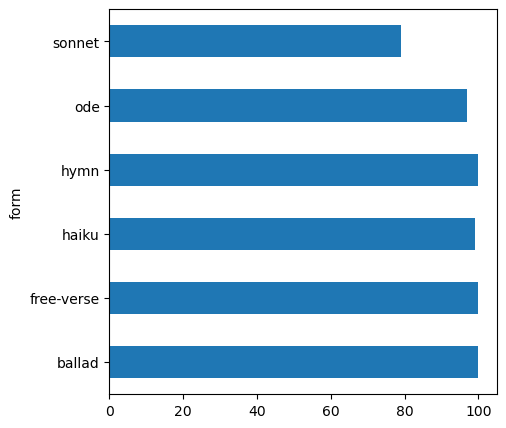

In [7]:
df_form.groupby('form').file.count().plot(kind='barh', figsize=(5,5))
plt.show()

**Topics**

In [8]:
topics_dir = pathlib.Path(os.path.join('/kaggle/input/poemsdataset', 'topics'))

In [9]:
data = []
for topic in topics_dir.iterdir():
    for file in topic.iterdir():
        with file.open('r') as f:
            text = f.read()
        data.append(
            {
                'topic': str(topic).rsplit('/')[-1],
                'file': str(file).rsplit('/')[-1][:-4],
                'text': text
            }
        )

In [10]:
def func(value):
    return ' '.join(value.splitlines())

df_topic = pd.DataFrame(data)
df_topic["Number of Words"] = df_topic["text"].apply(lambda n: len(n.split()))
df_topic["clean_text"] = df_topic["text"].apply(lambda n: func(n))
print("Total number of words:", df_topic["Number of Words"].sum())
print("The number of rows in the Dataframe is:", len(df_topic.index))
print("Unique words\n", df_topic.nunique())
display(df_topic)

Total number of words: 2632171
The number of rows in the Dataframe is: 14335
Unique words
 topic                144
file               14335
text               13737
Number of Words      925
clean_text         13735
dtype: int64


,topic,file,text,Number of Words,clean_text
0,moon,MoonPoemsSonnetXlivPressDByTheMoonPoembyCharlo...,"Press'd by the Moon, mute arbitress of tides,\...",110,"Press'd by the Moon, mute arbitress of tides, ..."
1,moon,MoonPoemsFromAFullMoonInMarchPoembyWilliamButl...,PARNELL'S FUNERAL\nUNDER the Great Comedian's ...,332,PARNELL'S FUNERAL UNDER the Great Comedian's t...
2,moon,MoonPoemsFaceOfTheSpringMoonPoembyKobayashiIssa,Face of the spring moon--\nabout twelve years ...,15,Face of the spring moon-- about twelve years o...
3,moon,MoonPoemsTheMoonIsAPainterPoembyVachelLindsay,He coveted her portrait.\nHe toiled as she gre...,108,He coveted her portrait. He toiled as she grew...
4,moon,MoonPoemsWhiteInTheMoonTheLongRoadLiesPoembyAl...,"White in the moon the long road lies,\nThe moo...",101,"White in the moon the long road lies, The moon..."
...,...,...,...,...,...
14330,innocence,InnocencePoemsInnocenceAnAutobiographyPoembySh...,"I don't know when I was born,\nMaybe when huma...",185,"I don't know when I was born, Maybe when human..."
14331,innocence,InnocencePoemsInnocenceNeverDiesPoembyCPSharma,Who says the Christ was crucified?\nWho says t...,116,Who says the Christ was crucified? Who says th...
14332,innocence,InnocencePoemsCryOfInnocencePoembyDaveAlanWalker,Does anyone listen\nfor the cries\nof the inno...,51,Does anyone listen for the cries of the innoce...
14333,innocence,InnocencePoemsInnocenceStolenPoembyLindaNorth,You crawled into my bed\nTo make love for the ...,140,You crawled into my bed To make love for the f...


**Dividing Topics into Categories**

In [20]:
CATEGORIES = {
    'emotions': [
        'joy',
        'sorrow',
        'greed',
        'fear',
        'laughter',
        'passion',
        'love',
        'hate',
        'happiness',
        'happy',
        'sympathy',
        'despair',
        'depression',
        'hope',
        'anger', 
        'thanks'
    ],
    'harm': [
        'lust',
        'greed',
        'murder', 
        'racism',
        'evil', 
        'war', 
        'sick',
        'suicide', 
        'lost',
        'loss'
    ],
    'family': [
        'father',
        'husband',
        'mother',
        'daughter',
        'brother',
        'sister',
        'son',
        'family',
        'house',
        'home',
        'children', 
        'baby', 
    ],
    'youth': [
        'friend',
        'school',
        'girl',
        'teacher', 
        'kiss', 
        'romantic',
        'romance',
        'graduation'
    ],
    'virtues': [
        'respect',
        'truth',
        'justice',
        'peace',
        'freedom',
        'courage',
        'innocence',
        'beauty',
        'trust',
        'change'
    ],
    'nature': [
        'butterfly',
        'frog',
        'snake',
        'river',
        'ocean',
        'rose',
        'moon',
        'sun',
        'sky',
        'star',
        'rain',
        'rainbow',
        'beach',
        'sea',
        'nature',
        'animal', 
        'water'
    ],
    'locations': [
        'paris',
        'chicago',
        'america',
        'city',
        'world'
    ],
    'activities': [
        'swimming',
        'dance',
        'football',
        'hunting',
        'travel'
    ],
    'art': [
        'poem',
        'music',
        'poetry', 
        'culture',
        'song',
    ], 
    'fantasy': [
        'angel',
        'hero', 
        'heaven', 
        'god',
        'dream',
        'believe', 
        'faith', 
        'destiny'
    ],
    'seasons': [
      'january', 
      'june', 
      'june',
      'christmas',
       'spring',
       'winter',
       'summer',
      'weather',
    ],
    'life_stages': [
        'life',
        'childhood',
        'birth', 
        'death', 
        'work',
        'graduation',
        'marriage',
        'wedding', 
        'funeral'
    ],
    'other': [
        'sometimes', 
        'pink', 
        'green', 
        'fire', 
        'future', 
        'alone', 
        'funny', 
        'silver', 
        'mirror', 
        'warning', 
        'dark', 
        'beautiful', 
        'running',
        'remember', 
        'today', 
        'power', 
        'together', 
        'time', 
        'red', 
        'cinderella', 
        'success', 
        'crazy', 
        'lonely', 
        'memory', 
        'money', 
        'soldier', 
        'identity', 
        'poverty', 
        'food', 
        'car', 
        'hair', 
        'sleep',
        'night', 
    ]
}

data1 = []
data2 = []
data3 = []
data4 = []
data5 = []
data6 = []
data7 = []
data8 = []
data9 = []
data10 = []
data11 = []
data12 = []
data13 = []

for index, row in df_topic.iterrows():
    if(row['topic'] in CATEGORIES['emotions']):
        data1.append(
            {
                'topic': "Emotion",
                'file': row['file'],
                'text': row['text']
            }
        )
    elif(row['topic'] in CATEGORIES['harm']):
        data2.append(
            {
                'topic': "Emotion",
                'file': row['file'],
                'text': row['text']
            }
        )
    elif(row['topic'] in CATEGORIES['family']):
        data3.append(
            {
                'topic': "Emotion",
                'file': row['file'],
                'text': row['text']
            }
        )
    elif(row['topic'] in CATEGORIES['youth']):
        data4.append(
            {
                'topic': "Emotion",
                'file': row['file'],
                'text': row['text']
            }
        )
    elif(row['topic'] in CATEGORIES['virtues']):
        data5.append(
            {
                'topic': "Emotion",
                'file': row['file'],
                'text': row['text']
            }
        )
    elif(row['topic'] in CATEGORIES['nature']):
        data6.append(
            {
                'topic': "Emotion",
                'file': row['file'],
                'text': row['text']
            }
        )
    elif(row['topic'] in CATEGORIES['locations']):
        data7.append(
            {
                'topic': "Emotion",
                'file': row['file'],
                'text': row['text']
            }
        )
    elif(row['topic'] in CATEGORIES['activities']):
        data8.append(
            {
                'topic': "Emotion",
                'file': row['file'],
                'text': row['text']
            }
        )
    elif(row['topic'] in CATEGORIES['art']):
        data9.append(
            {
                'topic': "Emotion",
                'file': row['file'],
                'text': row['text']
            }
        )
    elif(row['topic'] in CATEGORIES['fantasy']):
        data10.append(
            {
                'topic': "Emotion",
                'file': row['file'],
                'text': row['text']
            }
        )
    elif(row['topic'] in CATEGORIES['seasons']):
        data11.append(
            {
                'topic': "Emotion",
                'file': row['file'],
                'text': row['text']
            }
        )
    elif(row['topic'] in CATEGORIES['life_stages']):
        data12.append(
            {
                'topic': "Emotion",
                'file': row['file'],
                'text': row['text']
            }
        )
    elif(row['topic'] in CATEGORIES['other']):
        data13.append(
            {
                'topic': "Emotion",
                'file': row['file'],
                'text': row['text']
            }
        )
        
df_emotions = pd.DataFrame(data1)
df_emotions.to_csv("Emotions.csv")

df_harm = pd.DataFrame(data2)
df_harm.to_csv("Harm.csv")

df_family = pd.DataFrame(data3)
df_family.to_csv("Family.csv")

df_youth = pd.DataFrame(data4)
df_youth.to_csv("Youth.csv")

df_virtues = pd.DataFrame(data5)
df_virtues.to_csv("Virtues.csv")

df_nature = pd.DataFrame(data6)
df_nature.to_csv("Nature.csv")

df_locations = pd.DataFrame(data7)
df_locations.to_csv("Locations.csv")

df_activities = pd.DataFrame(data8)
df_activities.to_csv("Activities.csv")

df_art = pd.DataFrame(data9)
df_art.to_csv("Art.csv")

df_fantasy = pd.DataFrame(data10)
df_fantasy.to_csv("Fantasy.csv")

df_seasons = pd.DataFrame(data11)
df_seasons.to_csv("Seasons.csv")

df_lifestages = pd.DataFrame(data12)
df_lifestages.to_csv("LifeStages.csv")

df_other = pd.DataFrame(data13)
df_other.to_csv("OtherTopics.csv")

In [22]:
df_emotions['text'][0]

"Year's end is swiftly encroaching,\nLeaving the present year behind,\nThe New Year is fast approaching,\nThe goals we sought, did we find?\nWere we satisfied with mediocrity?\nDid we strive for so much less?\nDid we flaunt an air of superiority?\nDid we make of ourselves a pitiable mess?\nThe time is coming for a new resolution\nThe New Year offers new promise and hope\nWe plead with God for  His absolution\nAnd trust in His mercy to help us cope.\nStarting afresh, let us begin the New Year\nBy recalling His Tenets and  His Law\nRemembering that He is always near\nReady to catch us if and when we fall.\nSeas may rage and oceans may heave\nAnd fall we shall ~ but do not always fear it\nFor Jesus told us that He will never leave\nThrough the Power of His Holy Spirit.\nSpiritual things are seen and unseen\nIt is within the soul we come to know it;\nIn evaluating our walk we see where we've been\nGrowing in holiness ~ or ~ wallowing in sin\nForgiveness is needed without a doubt\nAnd when 